In [7]:
!pip install tensorflow pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten


In [8]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              61 non-null     object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.7+ MB
None


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [9]:
# Extract time features
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['holiday', 'weather_main'], drop_first=True)

# Drop unused text columns
df = df.drop(columns=['weather_description', 'date_time'])

# Check final columns
df.head()


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,dayofweek,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,5545,9,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,4516,10,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,4767,11,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,5026,12,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,4918,13,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [10]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, list(df.columns).index('traffic_volume')])  # predict traffic_volume
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_steps=24)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)



(38544, 24, 27) (9636, 24, 27)


In [11]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=15,
                              batch_size=32,
                              validation_split=0.1,
                              verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - loss: 0.0338 - val_loss: 0.0053
Epoch 2/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 3/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 4/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 5/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 6/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 7/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 8/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 9/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 10/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 11/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 12

In [12]:
model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_cnn_lstm.compile(optimizer='adam', loss='mse')

history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train,
                                      epochs=15,
                                      batch_size=32,
                                      validation_split=0.1,
                                      verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0440 - val_loss: 0.0071
Epoch 2/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 3/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 4/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 5/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 6/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 7/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 8/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 9/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 10/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 11/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 12

In [16]:
from sklearn.metrics import r2_score
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse scale for traffic_volume only
    traffic_index = list(df.columns).index('traffic_volume')
    dummy_test = np.zeros((len(y_test), scaled_data.shape[1]))
    dummy_test[:, traffic_index] = y_test
    y_test_inv = scaler.inverse_transform(dummy_test)[:, traffic_index]

    dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
    dummy_pred[:, traffic_index] = y_pred[:, 0]
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, traffic_index]
    r2 = r2_score(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

    return rmse, mape, r2, y_test_inv, y_pred_inv


In [17]:
rmse_lstm, mape_lstm, r2_lstm, y_test_inv_lstm, y_pred_inv_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
rmse_cnn, mape_cnn, r2_cnn, y_test_inv_cnn, y_pred_inv_cnn = evaluate_model(model_cnn_lstm, X_test, y_test, scaler)

print(f"LSTM Model → RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%,R²: {r2_lstm:.4f}")
print(f"CNN+LSTM Model → RMSE: {rmse_cnn:.2f}, MAPE: {mape_cnn:.2f}%,R²: {r2_cnn:.4f}")


302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM Model → RMSE: 369.50, MAPE: 12.62%,R²: 0.9648
CNN+LSTM Model → RMSE: 393.81, MAPE: 13.30%,R²: 0.9600


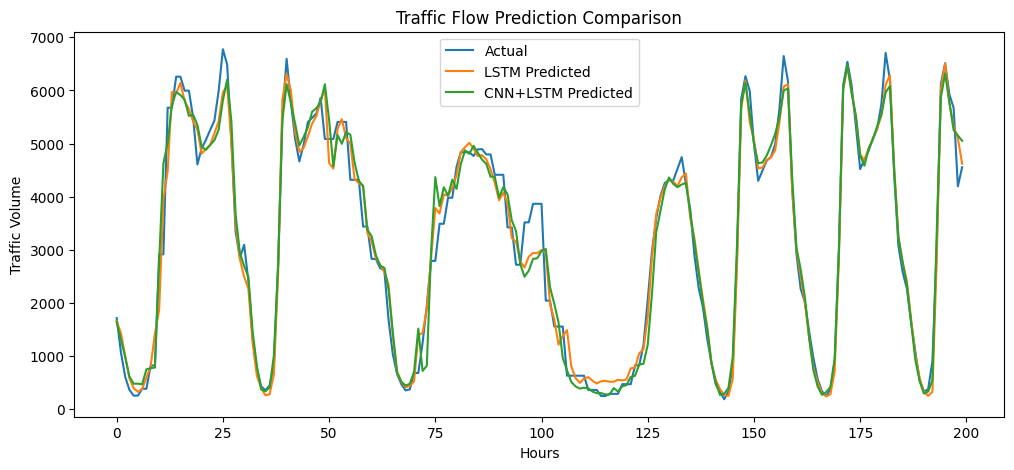

In [18]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv_lstm[:200], label='Actual')
plt.plot(y_pred_inv_lstm[:200], label='LSTM Predicted')
plt.plot(y_pred_inv_cnn[:200], label='CNN+LSTM Predicted')
plt.xlabel('Hours')
plt.ylabel('Traffic Volume')
plt.title('Traffic Flow Prediction Comparison')
plt.legend()
plt.show()
